In [325]:
# install necessary packages
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns

# suppress some annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

sns.set_theme(style='darkgrid') # If we don't call this, we just get default matplotlib styling
sns.set_context("notebook") # Set an overall scale. Notebook is the default. In increasing size: paper, notebook, talk, poster.
rcParams['font.sans-serif'] = ['Calibri','Segoe UI','Arial'] # use a nicer font in matplotlib (if available)

In [326]:
# import the dataset
df = pd.read_csv('data/weatherAUS.csv')

In [327]:
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [328]:
# convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# drop the partial years (2007,2017)
df['year'] = df['Date'].dt.year
df = df[~df['year'].isin([2007,2017])]

# convert 'RainTomorrow' to a numeric variable, where 'Yes' = 1 and 'No' = 0.
df['RainToday']=df['RainToday'].replace({'Yes': 1, 'No': 0, 'NA':0}).fillna(0).astype(int)
df['RainTomorrow']=df['RainTomorrow'].map({'Yes': 1, 'No': 0,'NA': 0}).fillna(0).astype(int); 

# little tip: the semicolon suppresses textual output when we don't want it

# Pivoting, summarising and filtering data

In [329]:
# we need a month order for our "mmm" months - there is probably an official way of doing this...
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# build a month column
df['month'] = df['Date'].dt.strftime('%b') # Add a column that just contains the month in mmm format
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True) # Make it categorical using our custom order so that it appears in the right order

# we're going to filter to top 5 cities from now on
df_top5Cities = df[df['Location'].isin(['Perth','Adelaide','Sydney','Melbourne','Brisbane'])]

# a grouped dataframe with the number of rainy days per year and month, and location
df_top5Cities_rainyDays = df_top5Cities.groupby(['Location','year', 'month'])['RainToday'].sum().reset_index()

# a couple of fully-pivoted dataframes
df_top5Cities_Rainfall_grouped = df_top5Cities.groupby(['Location', 'month'])['Rainfall'].mean().reset_index()
df_top5Cities_Rainfall_pivoted = df_top5Cities_Rainfall_grouped.pivot(index="Location",columns="month", values="Rainfall")
df_top5Cities_rainyDays_pivoted = df_top5Cities.groupby(['Location', 'month'])['RainToday'].sum().reset_index().pivot(index="Location",columns="month", values="RainToday")
df_top5Cities_monthly_rainyDays_pivoted = df_top5Cities.groupby(['Location', 'month','year'])['RainToday'].sum().reset_index().groupby(['Location','month'])['RainToday'].mean().reset_index().pivot(index="Location",columns="month", values="RainToday")


# we need a sort order for our city names. This just returns an array with our city names in alphabetical order.
colOrder_top5Cities=sorted(df_top5Cities['Location'].unique())

In [330]:
df_top5Cities_monthly_rainyDays_pivoted.head()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Location,,,,,,,,,,,,
Adelaide,2.555556,1.555556,3.666667,4.000000,7.666667,8.555556,13.444444,11.444444,7.888889,4.222222,4.000000,4.555556
Brisbane,8.000000,7.111111,10.000000,5.333333,5.555556,6.222222,4.111111,3.555556,4.111111,5.888889,6.888889,8.777778
Melbourne,2.777778,2.333333,3.666667,3.555556,6.000000,6.888889,7.111111,7.666667,7.666667,7.666667,6.444444,5.222222
Perth,1.666667,0.666667,1.555556,3.444444,7.000000,9.111111,13.111111,11.222222,10.888889,4.666667,3.777778,1.666667
Sydney,6.111111,8.111111,8.111111,9.666667,6.222222,10.333333,7.888889,5.666667,5.666667,7.111111,8.222222,6.666667


In [331]:
# Calculate the date range dynamically; we're going to use this later...
date_min = df['Date'].min().strftime('%Y')
date_max = df['Date'].max().strftime('%Y')
date_range = f"{date_min} - {date_max}"

print(date_range)

2008 - 2016


# Plotting with Seaborn
https://seaborn.pydata.org/examples/index.html

## The absolute basics

In [332]:
print(df_top5Cities_Rainfall_pivoted.T)

Location  Adelaide  Brisbane  Melbourne     Perth    Sydney
month                                                      
Jan       0.672199  6.415574   0.982857  0.364516  3.323387
Feb       0.973604  5.325389   2.290909  0.284848  3.953304
Mar       1.171667  4.442276   1.702353  0.632258  3.811470
Apr       1.461165  3.165385   1.687500  1.271429  5.500000
May       2.293860  3.126446   1.624615  3.045161  2.597133
Jun       2.447009  2.516318   2.247191  3.613333  5.733086
Jul       2.873606  1.000000   1.632110  4.300358  2.853047
Aug       2.399237  1.273381   1.734247  3.278853  2.156272
Sep       1.809125  1.314498   2.054054  2.746667  1.817844
Oct       0.906273  2.419424   1.977578  0.998566  2.164029
Nov       0.730827  3.347761   2.736538  0.976296  2.913534
Dec       1.192500  4.551613   2.093069  0.525806  2.391935


<Axes: xlabel='month'>

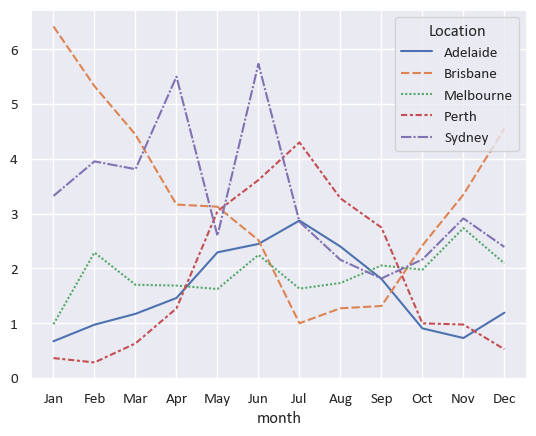

In [333]:
sns.lineplot(data=df_top5Cities_Rainfall_pivoted.T) #.T gives the transpose

## A tiny bit of customisation

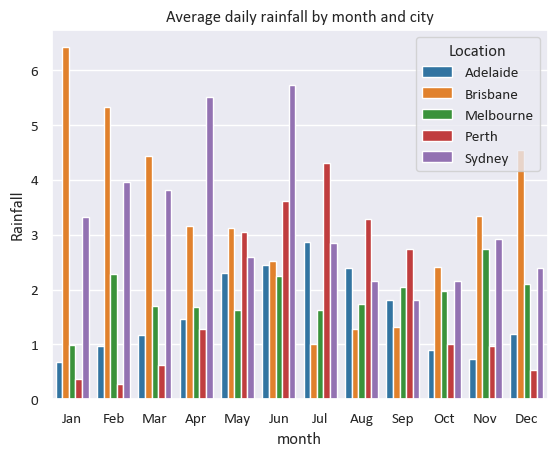

In [334]:
sns.barplot(data=df_top5Cities_Rainfall_grouped 
            ,x="month"
            ,y="Rainfall"
            ,hue="Location" # read "hue" as "series"
            ,palette="tab10" # https://matplotlib.org/stable/users/explain/colors/colormaps.html
           ).set(title='Average daily rainfall by month and city');

## Heatmaps

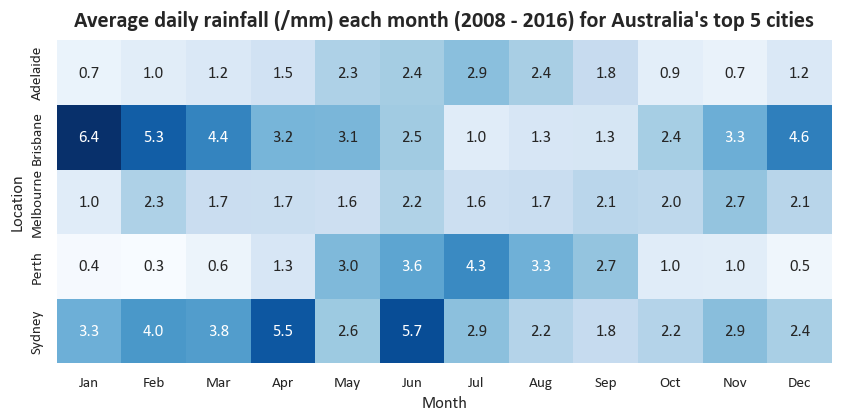

In [335]:
# We need to use some matplotlib code to set our output size, add a title, and capitalise our x-axis label
f,ax = plt.subplots(figsize=(10, 5)) 
ax.set_title(f"Average daily rainfall (/mm) each month ({date_range}) for Australia's top 5 cities", fontsize=16, fontweight="bold", pad=10)

sns.heatmap(df_top5Cities_Rainfall_pivoted # Heatmap expects rectangular (pivot-like) data
            ,annot=True # Put numbers inside the cells
            ,fmt=".1f" # Make the numbers have 1 decimal place
            ,square=True # Square vs rectangular cells
            ,cbar=False # Get rid of the colourbar legend on the side
            ,cmap="Blues" # Seems appropriate for rainfall. Colourmaps reference: https://matplotlib.org/stable/users/explain/colors/colormaps.html 
            ,ax=ax # Tell it to use the matplotlib axes we created earlier
           )

ax.set(xlabel="Month")
plt.show()

## Another heatmap with a bit more customisation

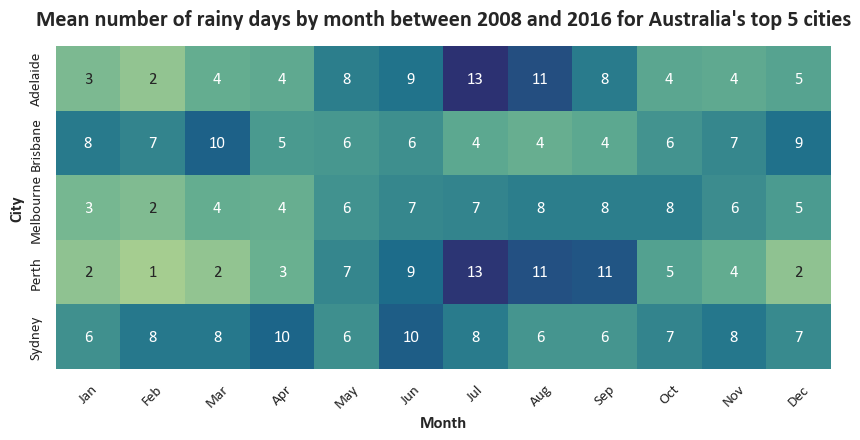

In [336]:
# Setting up matplotlib subplots so that we can make some changes later
f,ax = plt.subplots(figsize=(10, 5)) 

sns.heatmap(df_top5Cities_monthly_rainyDays_pivoted # Heatmap expects rectangular (pivot-like) data
            ,annot=True # Put numbers inside the cells
            ,fmt=".0f" # Force the number format
            ,square=True # Square vs rectangular cells
            ,cbar=False # Get rid of the colourbar legend on the side
            ,cmap="crest" # Colourmaps reference: https://matplotlib.org/stable/users/explain/colors/colormaps.html 
            ,ax=ax # Tell it to use the matplotlib axes we created earlier
           )

# We need to use some matplotlib code to set our output size, add a title, and capitalise our x-axis label
ax.tick_params(axis='x', labelsize=11, rotation=45) # I think 45-degree month labels look nicer, but this is a matter of taste.
ax.tick_params(axis='y', labelsize=11)

# Manually changing our axis labels for more control
ax.set_xlabel("Month",fontweight="bold",fontsize=12) 
ax.set_ylabel("City",fontweight="bold",fontsize=12)

# Set our title dynamically
ax.set_title(f"Mean number of rainy days by month between {date_min} and {date_max} for Australia's top 5 cities", fontsize=16, fontweight="bold", pad=15);

## A slightly fancier, multi-chart visual

https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

https://seaborn.pydata.org/generated/seaborn.boxplot.html

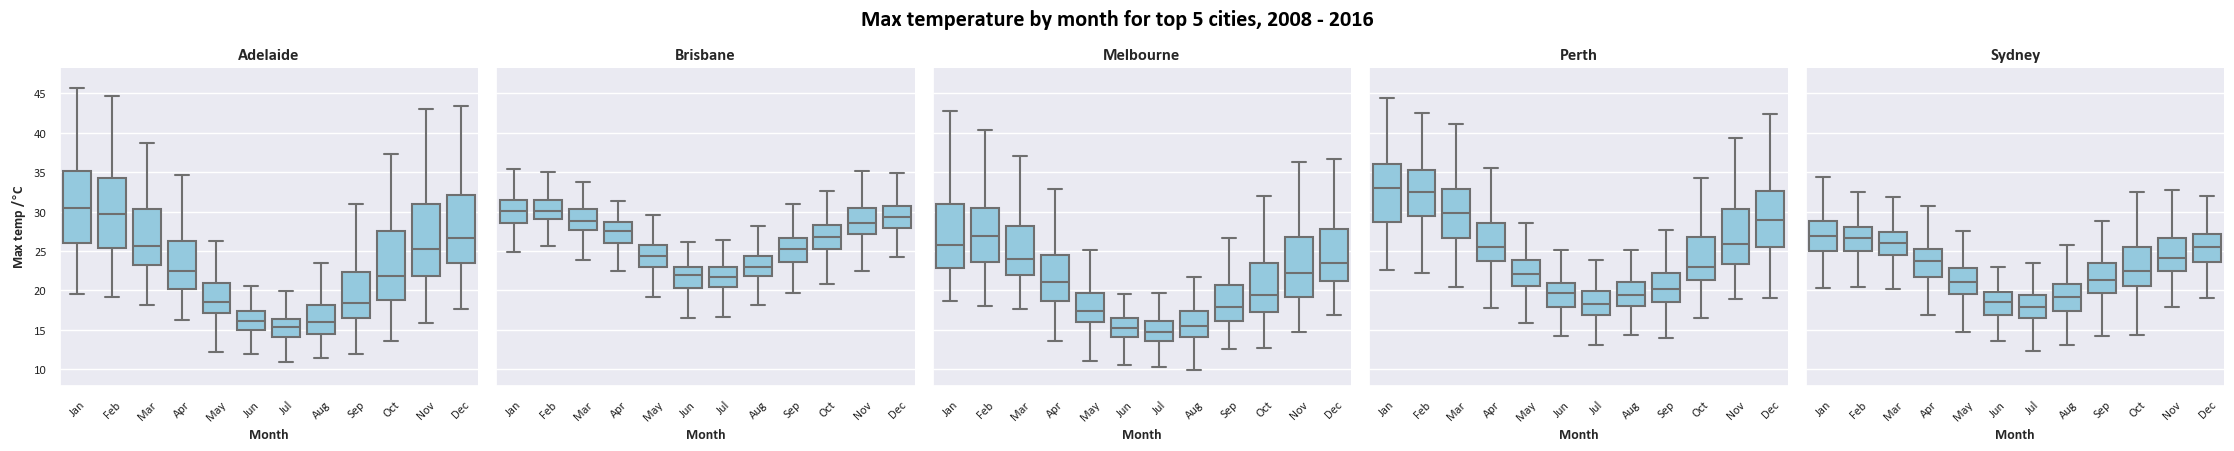

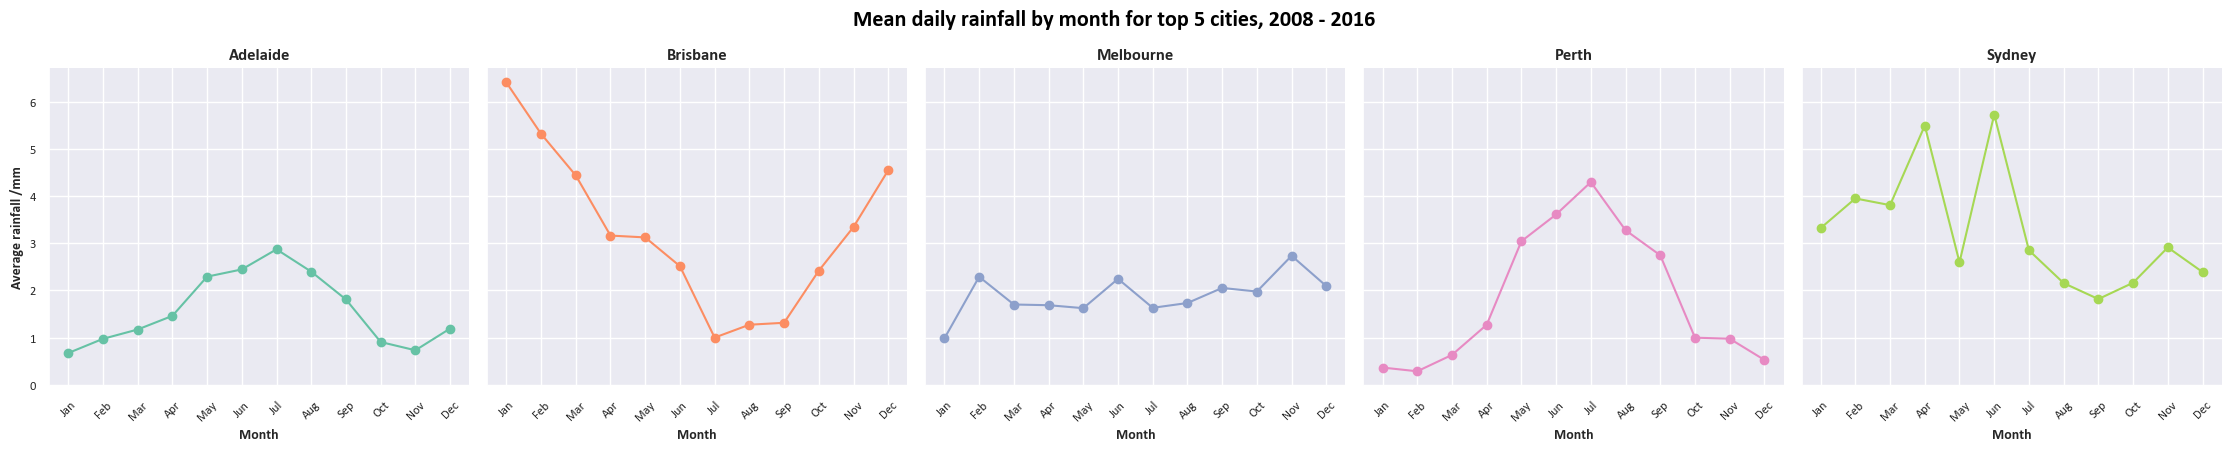

In [337]:
# Setting up the grid of box plots
# Box plots are a bit of a rabbit hole and are extremely customisable; we're mostly using defaults here
boxgrid = sns.FacetGrid(df_top5Cities 
                        ,col="Location" # Defining the different facets
                        ,col_wrap=5, height=4.5 # Layout and sizing for our facet grid
                        ,col_order=colOrder_top5Cities  # Using our alphabetical order of city names to arrange our facets
)
boxgrid.map(sns.boxplot # This is what tells sns what sort of plots we want in our grid
            ,"month" # X
            ,"MaxTemp" # Y
            ,linewidth=1.5
            ,color="skyblue"
            ,order=month_order
            ,fliersize=0 # Seaborn boxplots by default include markers for outliers, which it calls "fliers". For this chart we'd like to disable these.
            ) 

# Setting up the grid of line plots
# Using the default matplotlib plot here
linegrid = sns.FacetGrid(df_top5Cities.groupby(['Location', 'month'])['Rainfall'].mean().reset_index()
                         ,col="Location" 
                         ,hue="Location",palette="Set2" 
                         ,col_wrap=5, height=4.5 
                         ,col_order=colOrder_top5Cities
)
linegrid.map(plt.plot, "month", "Rainfall",marker="o")

# Formatting axes
for ax in boxgrid.axes.flat:
    ax.tick_params(axis='x', labelsize=9, rotation=45)
    ax.tick_params(axis='y', labelsize=9)
for ax in linegrid.axes.flat:
    ax.tick_params(axis='x', labelsize=9, rotation=45)
    ax.tick_params(axis='y', labelsize=9)

linegrid.set_titles(col_template="{col_name}",fontweight="bold",fontsize=16)
linegrid.set_axis_labels("Month","Average rainfall /mm",fontweight="bold",fontsize=10)
boxgrid.set_titles(col_template="{col_name}",fontweight="bold",fontsize=16)
boxgrid.set_axis_labels("Month","Max temp /$\\degree$C",fontweight="bold",fontsize=10)

# Setting overall titles and spacing
linegrid.fig.suptitle(f"Mean daily rainfall by month for top 5 cities, {date_range}", fontsize=16, color='black',fontweight='bold') 
boxgrid.fig.suptitle(f"Max temperature by month for top 5 cities, {date_range}", fontsize=16, color='black',fontweight='bold') 
linegrid.fig.subplots_adjust(top=0.85)  
boxgrid.fig.subplots_adjust(top=0.85);

## Alternatively, a 2-dimensional grid of location and year


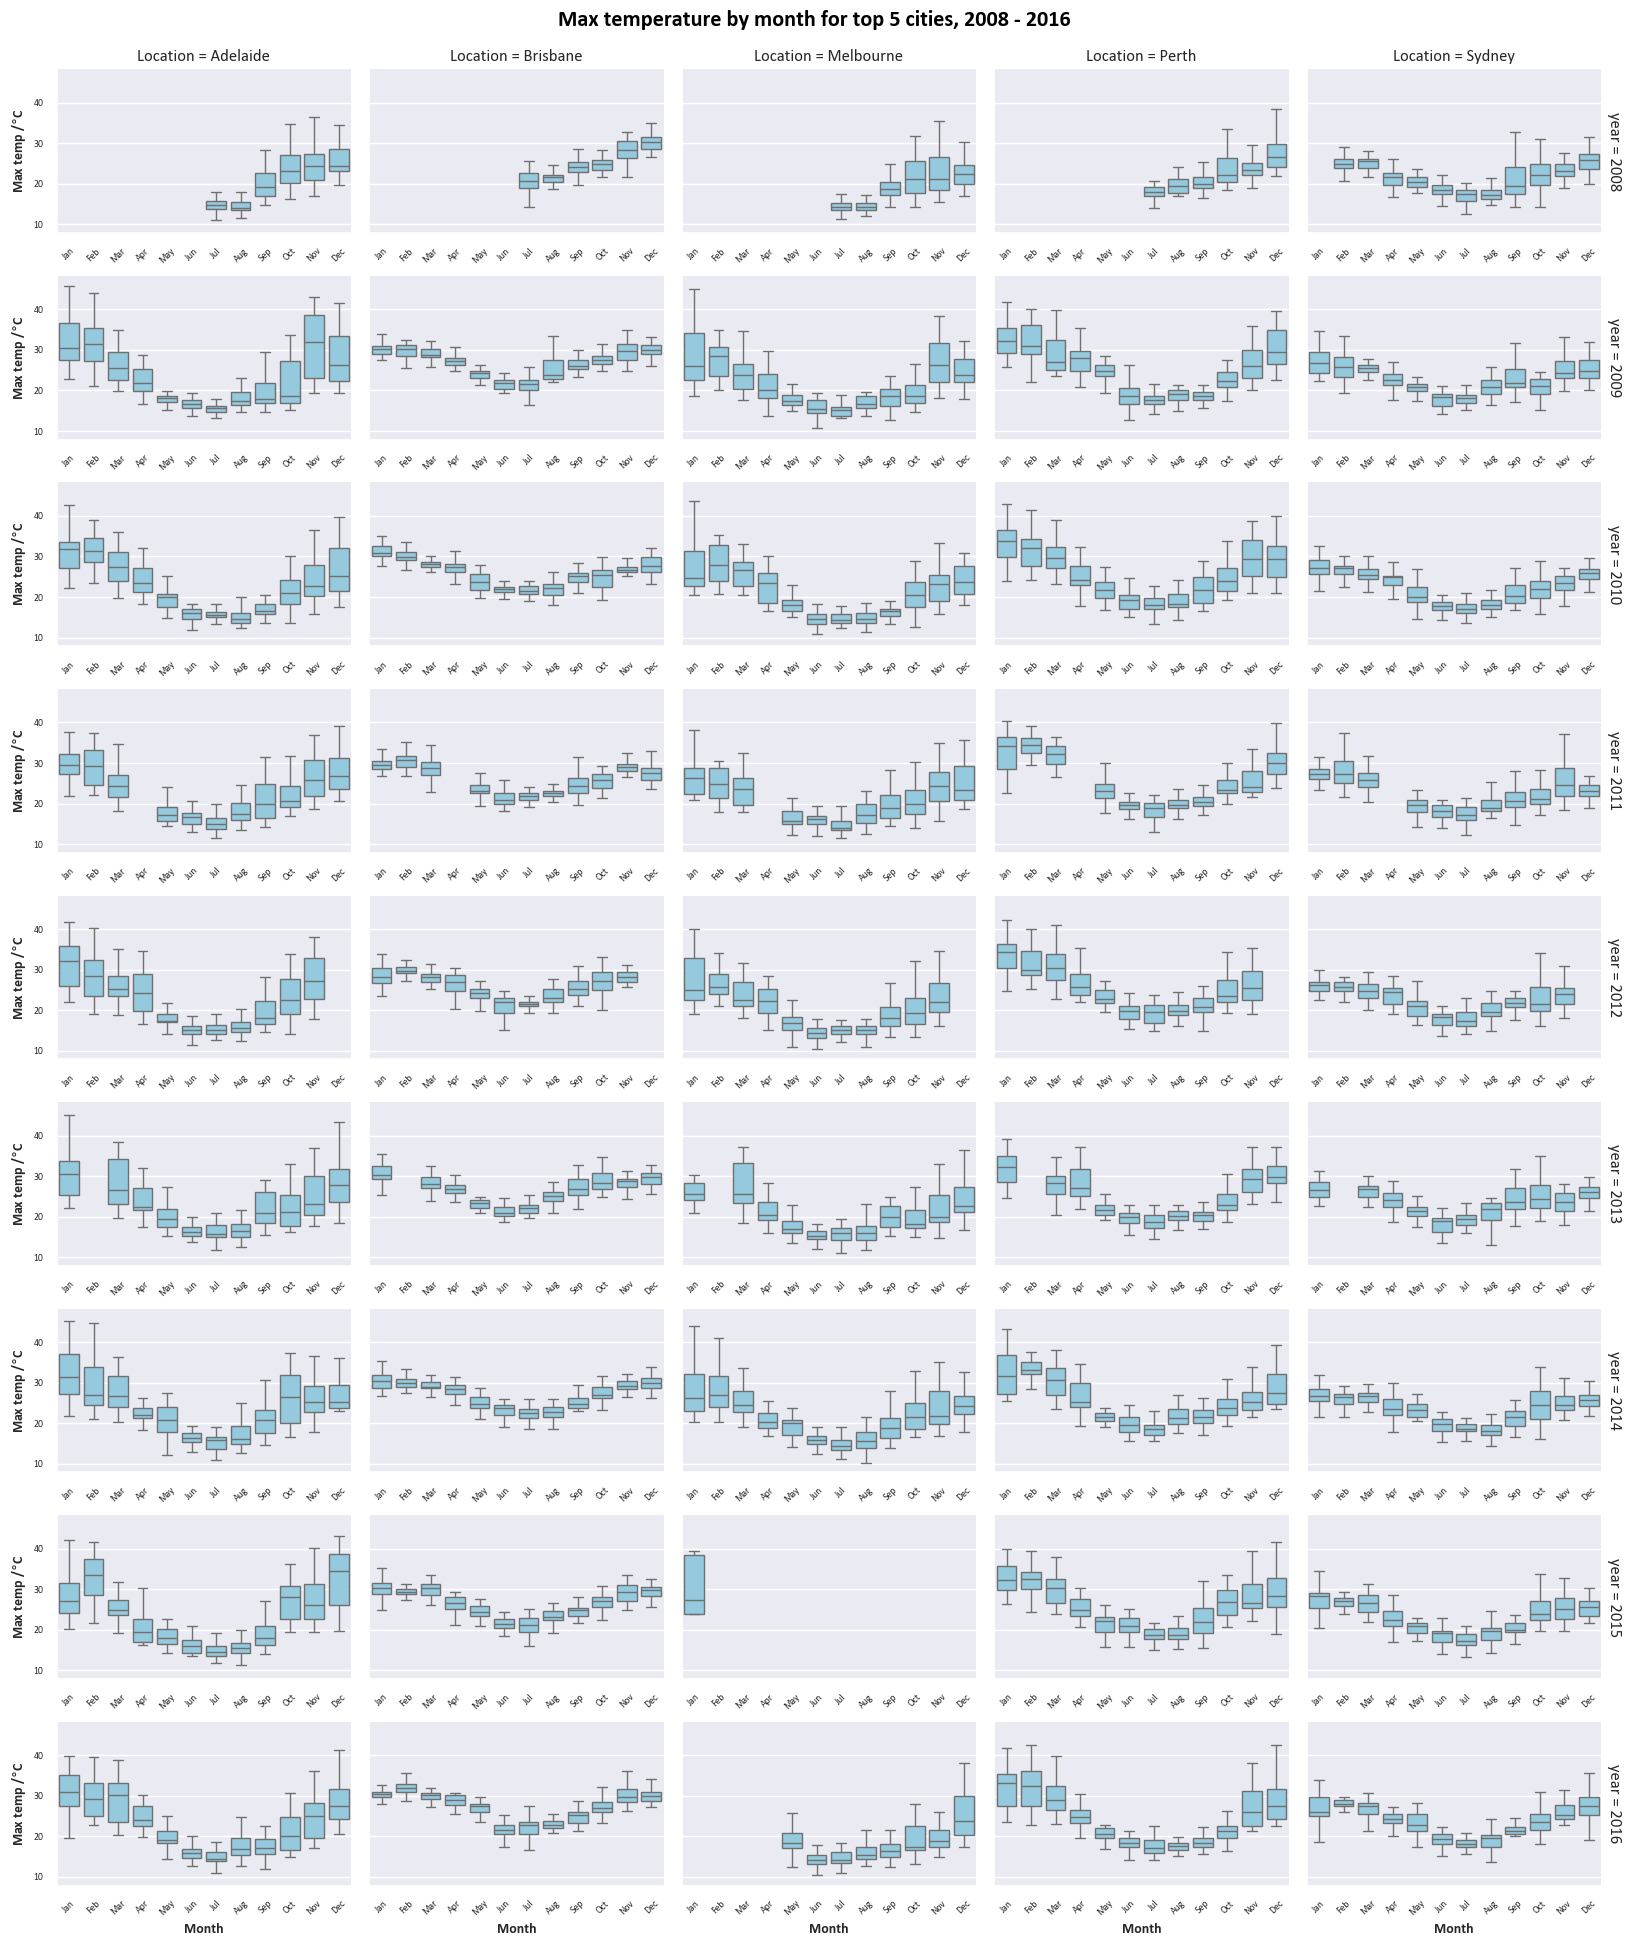

In [338]:
# Setting up the grid of box plots
# Box plots are a bit of a rabbit hole and are extremely customisable; we're mostly using defaults here
boxgrid = sns.FacetGrid(df_top5Cities 
                        ,col="Location" # Defining the different facets
                        ,row="year"
                        ,margin_titles=True
                        ,height=2.2 # Layout and sizing for our facet grid
                        ,aspect=1.5
                        ,sharex=False
                        ,col_order=colOrder_top5Cities  # Using our alphabetical order of city names to arrange our facets
)
boxgrid.map(sns.boxplot # This is what tells sns what sort of plots we want in our grid
            ,"month" # X
            ,"MaxTemp" # Y
            ,color="skyblue"
            ,order=month_order
            ,fliersize=0 # Seaborn boxplots by default include markers for outliers, which it calls "fliers". For this chart we'd like to disable these.
            ) 

# Formatting axes
for ax in boxgrid.axes.flat:
    ax.tick_params(axis='x', labelsize=7, rotation=45)
    ax.tick_params(axis='y', labelsize=7)

#boxgrid.set_titles(col_template="{col_name}",fontweight="bold",fontsize=16)
boxgrid.set_axis_labels("Month","Max temp /$\\degree$C",fontweight="bold",fontsize=10)

# Setting overall titles and spacing
boxgrid.fig.suptitle(f"Max temperature by month for top 5 cities, {date_range}", fontsize=16, color='black',fontweight='bold') 
boxgrid.fig.subplots_adjust(top=0.95);

## "Small multiple" time series grid

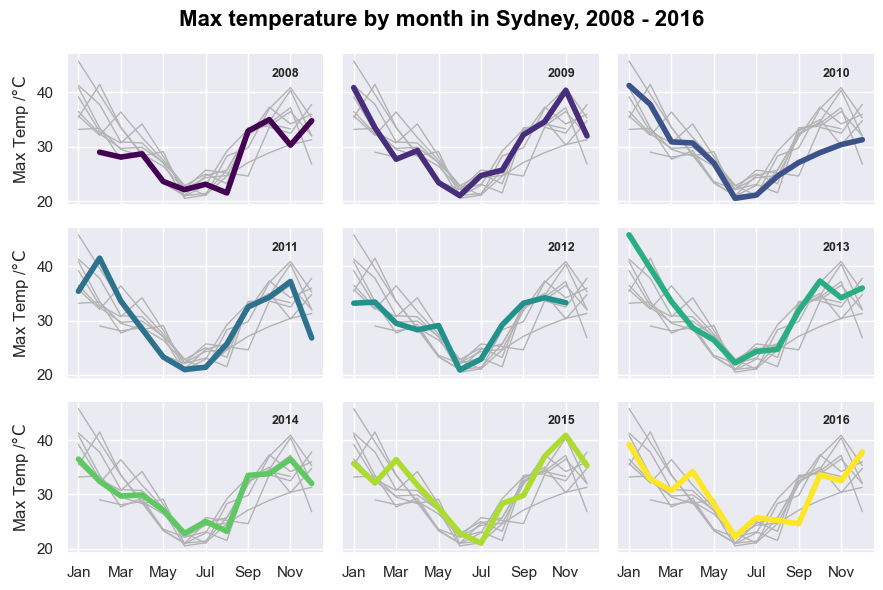

In [339]:
# Credit to https://seaborn.pydata.org/examples/timeseries_facets.html

df_Sydney = df[df['Location']=="Sydney"].groupby(['month', 'Location','year'], as_index=False)['MaxTemp'].max()
sns.set_theme()

#Plot each year's time series in its own facet
g = sns.relplot(data=df_Sydney
                ,x="month"
                ,y="MaxTemp"
                ,col="year"
                ,hue="year"
                ,kind="line"
                ,palette="viridis"
                ,linewidth=4
                ,zorder=5
                ,col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8
            ,.85
            ,year
            ,transform=ax.transAxes
            ,fontweight="bold",fontsize=9)

    # Plot every year's time series in the background
    sns.lineplot(
        data=df_Sydney, x="month", y="MaxTemp", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.fig.suptitle(f"Max temperature by month in Sydney, {date_range}", fontsize=16, color='black',fontweight='bold') 
g.set_axis_labels("", "Max Temp /$\\degree \\mathrm{C}$");
g.tight_layout();